# Lecture : Graph Transformers & Graph ViT

## Lab 03 : Graph Transformers with edge features and DGL (sparse linear algebra) -- Solution

### Xavier Bresson, Guoji Fu

Dwivedi, Bresson, A generalization of transformer networks to graphs, 2020   
https://arxiv.org/pdf/2012.09699.pdf


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/10_Graph_Transformers'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL


In [2]:
# Libraries
import pickle
import dgl
import dgl.function as fn
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time
import networkx as nx
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_ncut
from lib.molecules import Dictionary, MoleculeDataset, MoleculeDGL, Molecule
import os, datetime


# Load molecular datasets

In [3]:
# Select dataset
dataset_name = 'QM9_1.4k'; data_folder_pytorch = 'dataset/QM9_1.4k_pytorch/'; data_folder_dgl = 'dataset/QM9_1.4k_dgl/'

# Load the number of atom and bond types
with open(data_folder_pytorch + "atom_dict.pkl" ,"rb") as f: num_atom_type = len(pickle.load(f))
with open(data_folder_pytorch + "bond_dict.pkl" ,"rb") as f: num_bond_type = len(pickle.load(f))
print(num_atom_type)
print(num_bond_type)

# Load the DGL datasets
datasets_dgl = MoleculeDataset(dataset_name, data_folder_dgl)
trainset, valset, testset = datasets_dgl.train, datasets_dgl.val, datasets_dgl.test
print(len(trainset))
print(len(valset))
print(len(testset))
idx = 0
print(trainset[:2])
print(valset[idx])
print(testset[idx])


9
4
Loading datasets QM9_1.4k_dgl...
train, test, val sizes : 1000 200 200
Time: 0.9511s
1000
200
200
([Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), Graph(num_nodes=9, num_edges=18,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)})], [tensor([-0.2532]), tensor([1.0897])])
(Graph(num_nodes=9, num_edges=18,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([0.5060]))
(Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([-4.4048]))


# Add positional encoding feature

In [4]:
# Positional encoding as Laplacian eigenvectors
def LapEig_positional_encoding(g, pos_enc_dim):
    Adj = g.adj().to_dense() # Adjacency matrix
    Dn = ( g.in_degrees()** -0.5 ).diag() # Inverse and sqrt of degree matrix
    Lap = torch.eye(g.number_of_nodes()) - Dn.matmul(Adj).matmul(Dn) # Laplacian operator
    EigVal, EigVec = torch.linalg.eig(Lap) # Compute full EVD
    EigVal, EigVec = EigVal.real, EigVec.real # make eig real
    EigVec = EigVec[:, EigVal.argsort()] # sort in increasing order of eigenvalues
    EigVec = EigVec[:,1:pos_enc_dim+1] # select the first non-trivial "pos_enc_dim" eigenvector
    return EigVec

# Add node positional encoding features to graphs
pos_enc_dim = 3 # dimension of PE, QM9
def add_node_edge_features(dataset):
    for (graph,_) in dataset:
        graph.ndata['pos_enc'] = LapEig_positional_encoding(graph, pos_enc_dim) # node positional encoding feature
    return dataset

# Generate graph datasets
trainset = add_node_edge_features(trainset)
testset = add_node_edge_features(testset)
valset = add_node_edge_features(valset)
print(trainset[0])


(Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64), 'pos_enc': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([-0.2532]))


# Visualize positional encoding

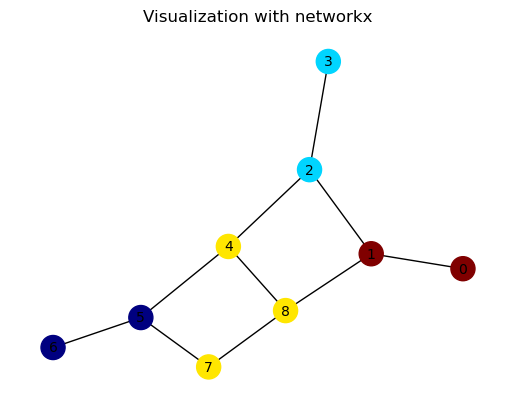

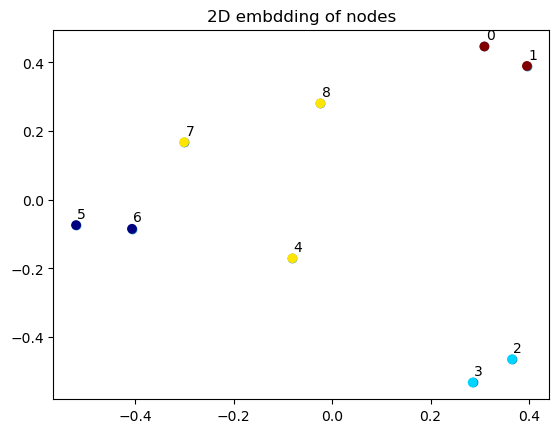

In [5]:
graph = trainset[0][0]

# Visualize graph
fig = plt.figure()
ax = fig.add_subplot(111)
Adj = graph.adj().to_dense()
A_nx = nx.from_numpy_array(Adj.numpy())
C = compute_ncut(Adj.long(), 4)
nx.draw(A_nx, ax=ax, node_color=C, cmap='jet', with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Visualization with networkx')
plt.show()

# plot 2D coordinates
fig = plt.figure()
ax = fig.add_subplot(111)
x = graph.ndata['pos_enc']
ax.scatter(x[:,0], x[:,1])
idx = list(range(graph.number_of_nodes()))
ax.scatter(x[:,0], x[:,1], c=C, cmap='jet')
for i, txt in enumerate(idx):
    ax.annotate(txt, (x[:,0][i], x[:,1][i]), textcoords="offset points", xytext=(1,5))
ax.title.set_text('2D embdding of nodes')
plt.show()


# Define the collate function to prepare a batch of DGL graphs and test it

In [6]:
# collate function prepares a batch of graphs, labels and other graph features (if needed)
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples))
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.stack(labels)  # batch of labels (here chemical target)
    return batch_graphs, batch_labels


# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
batch_x = batch_graphs.ndata['feat']
print('batch_x:',batch_x.size())
batch_pe = batch_graphs.ndata['pos_enc']
print('batch_pe:',batch_pe.size())
batch_e = batch_graphs.edata['feat']
print('batch_e:',batch_e.size())


Graph(num_nodes=87, num_edges=180,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64), 'pos_enc': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)})
tensor([[-0.5696],
        [ 0.0930],
        [-0.0904],
        [-1.5065],
        [-0.4760],
        [ 0.1606],
        [-0.2795],
        [ 2.8563],
        [-1.0082],
        [-2.6547]])
batch_x: torch.Size([87])
batch_pe: torch.Size([87, 3])
batch_e: torch.Size([180])


# Exercise 1: Design the class of GraphTransformer networks with edge features

Node update equation:  
\begin{eqnarray*}
\bar{h}^{\ell} &=&  h^{\ell} + \textrm{gMHA} (\textrm{LN}(h^{\ell}),\textrm{LN}(e^{\ell})) \in \mathbb{R}^{N\times d}\\
h^{\ell+1} &=& \bar{h}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{h}^{\ell}))  \in \mathbb{R}^{N\times d}\\
&&\textrm{with } \textrm{gMHA}(h,e)=\textrm{Concat}_{k=1}^H \left( \textrm{gHA}(h_k,e_k) \right) W_O \in \mathbb{R}^{N\times d},\ h_k\in \mathbb{R}^{N\times d'=d/H}, e_k\in \mathbb{R}^{E\times d'}, W_O\in \mathbb{R}^{d\times d} \\
&&\quad\quad\ \textrm{gHA}(h,e)_i= \sum_{j\in \mathcal{N}_i} \underbrace{\frac{\exp(q_i^T \textrm{diag}(e_{ij}) k_j/\sqrt{d'})}{ \sum_{j'\in\mathcal{N}_i} \exp(q_i^T \textrm{diag}(e_{ij'}) k_{j'}/\sqrt{d'}) }}_{\textrm{graph attention score w/ edge feature}_{ij}} v_j\ \textrm{ (point-wise equation)}\\
&&\quad\quad\ Q=h_k W_Q, K=h_k W_K, V=h_k W_V\in \mathbb{R}^{N\times d'=d/H}, E=e_k W_E\in \mathbb{R}^{E\times d'=d/H}, W_Q, W_K, W_V, W_E\in \mathbb{R}^{d'\times d'}\\
h^{\ell=0} &=& \textrm{LL}_1(h_0)+\textrm{LL}_2(p_0) \in \mathbb{R}^{N\times d}\ \textrm{(input node feature and positional encoding)}\\
&&\textrm{with } p_0=\Phi_{\{2,..,K+1\}}\in \mathbb{R}^{N\times K},\ \Delta = \Phi \Lambda \Phi^T \in \mathbb{R}^{N\times N}
\end{eqnarray*}

Edge update equation:  
\begin{eqnarray*}
\bar{e}^{\ell} &=&  e^{\ell} + \textrm{gMHE} (\textrm{LN}(e^{\ell}),\textrm{LN}(h^{\ell}))  \in \mathbb{R}^{E\times d}\\
e^{\ell+1} &=& \bar{e}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{e}^{\ell})) \in \mathbb{R}^{E\times d}\\
&&\textrm{with } \textrm{gMHE}(e,h)=\textrm{Concat}_{k=1}^H \left( \textrm{gHE}(e_k,h_k) \right) W_O^e \in \mathbb{R}^{E\times d},\ h_k\in \mathbb{R}^{N\times d'=d/H}, e_k\in \mathbb{R}^{E\times d'}, W_O^e\in \mathbb{R}^{d\times d} \\
&&\textrm{with } \textrm{gHE}(e,h)_{ij}=q_i \odot e_{ij} \odot k_j/\sqrt{d'} \in \mathbb{R}^{d'} \textrm{ (point-wise equation)}\\
e^{\ell=0} &=& \textrm{LL}(e_0) \in \mathbb{R}^{E\times d}\ \textrm{(input edge feature)}\\
\end{eqnarray*}


### Question 1.1: Implement a Graph Multi-Head Attention (MHA) Layer with edge features

**Instructions:**

- *Step 1 of message-passing with DGL:* Pass node feature and edge features along edges (src/j => dst/i) by:
    - *Step 1.1:* Compute bi-linear products with edge feature: $q_i^T * diag(e_{ij}) * k_j$. You may use ```edges.dst[]``` for ```i, edges.src[]``` for ```j, edges.data[]``` form ```ij```".  

    - *Step 1.2* Compute $\textrm{exp}_{ij} = \exp( q_i^T * k_j / \sqrt{d'} )$, ```size=(E,K,1)```.

    - *Step 1.3:* Obtain ```V```.

    - *Step 1.4:* Compute edge feature: $q_i^T * diag(e_{ij}) * k_j$.

    - *Step 1.5:* Update edge feature.

- *Step 2 of message-passing with DGL:* Define a reduce function that
    - *Step 2.1:* Use ```nodes.mailbox[]``` to collects all messages ```= {vj, eij}``` sent to node dst/i with *Step 1*.
    
    - *Step 2.2:* Sum/mean over the graph neigbors ```j``` in ```Ni```.

- Assign ```Q, K, V, E, F, G```  to graphs by storing them in the ndata dictionary with the keys ```'Q', 'K', 'V', 'E', 'F', 'G'``` for ```g.ndata[]``` and reshape them using ```.view(-1, num_heads, head_hidden_dim)```.

In [7]:
# class graph multi head attention layer
class graph_MHA_layer(nn.Module): # MHA = Multi Head Attention

    def __init__(self, hidden_dim, head_hidden_dim, num_heads): # hidden_dim = d
        super().__init__()
        self.head_hidden_dim = head_hidden_dim # head_hidden_dim = d' = d/K
        self.num_heads = num_heads # number of heads = K
        self.WQ = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True) # define K x W matrix of size=(d',d')
        self.WK = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WV = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WE = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)

    # Step 1 of message-passing with DGL:
    #   Node feature and edge features are passed along edges (src/j => dst/i)
    def message_func(self, edges):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Step 1.1: Compute bi-linear products with edge feature
        qikj = (edges.src['K'] * edges.data['E'] * edges.dst['Q']).sum(dim=2).unsqueeze(2) # size=(E,K,1), edges.src/dst/data[].size=(E,K,d')

        # Step 1.2: Compute exp_ij = exp( q_i^T * k_j / sqrt(d') ), size=(E,K,1)
        expij = torch.exp( qikj / torch.sqrt(torch.tensor(self.head_hidden_dim)) )

        # Step 1.3: Obtain vj
        vj = edges.src['V'] # size=(E,K,d')

        # Step 1.4: Compute edge feature: e_ij = q_i^T * diag(E_ij) * k_j / sqrt(d'), size=(E,K,d')
        eij = edges.src['K'] * edges.data['E'] * edges.dst['Q'] / torch.sqrt(torch.tensor(self.head_hidden_dim))

        # Step 1.5: Update edge feature
        edges.data['e'] = eij
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        return {'expij' : expij, 'vj' : vj}

    # Step 2 of message-passing with DGL:
    #   Reduce function collects all messages={hj, eij} sent to node dst/i with Step 1
    #                   and sum/mean over the graph neigbors j in Ni
    def reduce_func(self, nodes):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Step 2.1: Collects all messages= eij
        # size=(N,|Nj|,K,1), |Nj|=num_neighbors
        expij = nodes.mailbox['expij']

        # Step 2.1: Collects all messages= vj
        # size=(N,|Nj|,K,d')
        vj = nodes.mailbox['vj']

        # Step 2.2: Sum/mean over the graph neigbors j in Ni
        # sum_j exp_ij . v_j, size=(N,K,d')
        numerator = torch.sum( expij * vj, dim=1 )

        # sum_j' exp_ij', size=(N,K,1)
        denominator = torch.sum( expij, dim=1 )

        # h_i = sum_j score_ij . v_j , where score_ij = exp_ij / sum_j' exp_ij', size=(N,K,d')
        h = numerator / denominator
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        return {'h' : h}

    def forward(self, g, h, e):
        Q = self.WQ(h) # size=(N, d)
                       # computational trick to compute quickly K linear transformations h_k.WQ of size=(N, d')
                       # first compute linear transformation h.WQ of size=(N, d)
                       # then reshape h.WQ of size=(N, K, d'=d/K)
        K = self.WK(h) # size=(N, d)
        V = self.WV(h) # size=(N, d)
        E = self.WE(e) # size=(E, d)

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        g.ndata['Q'] = Q.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['K'] = K.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['V'] = V.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.edata['E'] = E.view(-1, self.num_heads, self.head_hidden_dim) # size=(E, K, d'=d/K)
        g.update_all(self.message_func, self.reduce_func) # compute with DGL the graph MHA
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        gMHA = g.ndata['h'] # size=(N, K, d'=d/K)
        gMHE = g.edata['e'] # size=(E, K, d'=d/K)
        return gMHA, gMHE




### Question 1.2: Implement a Graph Transformer layer (with edge feature)

- Implement dropout, layer normalization, and residual connection layers for edge features.

In [8]:
# class GraphTransformer layer
class GraphTransformer_layer(nn.Module):

    def __init__(self, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim # hidden_dim = d
        self.num_heads = num_heads # number of heads = K
        self.dropout_h_mha = nn.Dropout(dropout) # dropout value
        self.dropout_h_mlp = nn.Dropout(dropout) # dropout value
        self.gMHA = graph_MHA_layer(hidden_dim, hidden_dim//num_heads, num_heads) # graph MHA layer
        self.WO = nn.Linear(hidden_dim, hidden_dim) # LL
        self.layer_norm1 = nn.LayerNorm(hidden_dim) # layer normalization
        self.layer_norm1e = nn.LayerNorm(hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim) # LL1 for MLP
        self.linear2 = nn.Linear(hidden_dim, hidden_dim) # LL2 for MLP

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Dropout layers for edge features
        self.dropout_e_mha = nn.Dropout(dropout) # dropout value
        self.dropout_e_mlp = nn.Dropout(dropout) # dropout value

        # MLP layers for edge features
        self.WOe = nn.Linear(hidden_dim, hidden_dim) # LL

        # Layer normalization for edge features
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.layer_norm2e = nn.LayerNorm(hidden_dim)

        # MLP layers for edge features
        self.linear1e = nn.Linear(hidden_dim, hidden_dim) # LL1 for MLP
        self.linear2e = nn.Linear(hidden_dim, hidden_dim) # LL2 for MLP
        ###############################################
        # YOUR CODE ENDS
        ###############################################

    def forward(self, g, h, e):

        # Self-attention layer
        h_rc = h # size=(N,d), V=num_nodes, for residual connection
        e_rc = e
        h = self.layer_norm1(h) # layer normalization, size=(N, d)
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # layer normalization for edge features, size=(N, d)
        e = self.layer_norm1e(e)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        h_MHA, e_MHE = self.gMHA(g, h, e) # MHA, size=(N, K, d'=d/K)
        h_MHA = h_MHA.view(-1, self.hidden_dim) # size=(N, d)
        h_MHA = self.dropout_h_mha(h_MHA) # dropout, size=(N, d)
        h_MHA = self.WO(h_MHA) # LL, size=(N, d)
        h = h_rc + h_MHA # residual connection, size=(N, d)

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Update for edge features
        e_MHE = e_MHE.view(-1, self.hidden_dim) # size=(N, d)
        e_MHE = self.dropout_e_mha(e_MHE) # dropout, size=(N, d)
        e_MHE = self.WOe(e_MHE) # LL, size=(N, d)
        e = e_rc + e_MHE # residual connection, size=(N, d)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        # Fully-connected layer
        h_rc = h # for residual connection, size=(N, d)
        e_rc = e # for residual connection, size=(N, d)
        h = self.layer_norm2(h) # layer normalization, size=(N, d)
        e = self.layer_norm2e(e) # layer normalization, size=(N, d)
        h_MLP = self.linear1(h) # LL, size=(H, d)
        e_MLP = self.linear1e(e) # LL, size=(H, d)
        h_MLP = torch.relu(h_MLP) # size=(N, d)
        e_MLP = torch.relu(e_MLP) # size=(N, d)
        h_MLP = self.dropout_h_mlp(h_MLP) # dropout, size=(N, d)
        e_MLP = self.dropout_e_mlp(e_MLP) # dropout, size=(N, d)
        h_MLP = self.linear2(h_MLP) # LL, size=(N, d)
        e_MLP = self.linear2e(e_MLP) # LL, size=(N, d)
        h = h_rc + h_MLP # residual connection, size=(N, d)
        e = e_rc + e_MLP # residual connection, size=(N, d)

        return h, e




### Question 1.3: Combine all previous defined MLP Layer, GraphTransformer layer to construct the Graph Transformer network (with edge feature)

**Instructions:**

- *Adding a input edge embedding layer:* Initialize a linear layer ```nn.Linear()``` to convert input edge features into edge embeddings.

- *Graph transformer layer (with edge feature):* Initialize a ModuleList ```nn.ModuleList()``` containing ```L``` instances of ```GraphTransformer_layer()```.

In [9]:
# class Graph Transformer network
class GraphTransformer_net(nn.Module):

    def __init__(self, net_parameters):
        super(GraphTransformer_net, self).__init__()
        input_dim = net_parameters['input_dim']
        pos_enc_dim = net_parameters['pos_enc_dim']
        hidden_dim = net_parameters['hidden_dim']
        num_heads = net_parameters['num_heads']
        L = net_parameters['L']
        self.embedding_h = nn.Embedding(num_atom_type, hidden_dim)

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Initialize a edge embedding layer
        self.embedding_e = nn.Embedding(num_bond_type, hidden_dim)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        self.embedding_pe = nn.Linear(pos_enc_dim, hidden_dim)
        self.GraphTransformer_layers = nn.ModuleList([ GraphTransformer_layer(hidden_dim, num_heads) for _ in range(L) ])
        self.ln_h_final = nn.LayerNorm(hidden_dim)
        self.linear_h_final = nn.Linear(hidden_dim, 1, bias=True)

    def forward(self, g, h, pe, e):

        # input node embedding
        h = self.embedding_h(h) # size=(num_nodes, hidden_dim)

        ###############################################
        # YOUR CODE STARTS
        ###############################################
        # Implement teh edge embedding layer
        # size=(num_edges, hidden_dim)
        e = self.embedding_e(e)
        ###############################################
        # YOUR CODE ENDS
        ###############################################

        # graph convnet layers
        for GT_layer in self.GraphTransformer_layers:
            h, e = GT_layer(g, h, e) # size=(num_nodes, hidden_dim)

        # MLP classifier
        g.ndata['h'] = h
        mol_token = dgl.mean_nodes(g,'h') # DGL mean function over the neighbors, size=(num_graphs, hidden_dim)
        y = self.ln_h_final(mol_token)
        y = self.linear_h_final(y) # size=(num_graphs, num_classes)

        return y




In [10]:
# Instantiate one network (testing)
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
net = GraphTransformer_net(net_parameters)
print(net)

batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
batch_x = batch_graphs.ndata['feat']
batch_pe = batch_graphs.ndata['pos_enc']
batch_e = batch_graphs.edata['feat']
batch_labels = batch_labels
batch_scores = net(batch_graphs, batch_x, batch_pe, batch_e)
print(batch_scores.size())


GraphTransformer_net(
  (embedding_h): Embedding(9, 128)
  (embedding_e): Embedding(4, 128)
  (embedding_pe): Linear(in_features=3, out_features=128, bias=True)
  (GraphTransformer_layers): ModuleList(
    (0-3): 4 x GraphTransformer_layer(
      (dropout_h_mha): Dropout(p=0.0, inplace=False)
      (dropout_h_mlp): Dropout(p=0.0, inplace=False)
      (gMHA): graph_MHA_layer(
        (WQ): Linear(in_features=128, out_features=128, bias=True)
        (WK): Linear(in_features=128, out_features=128, bias=True)
        (WV): Linear(in_features=128, out_features=128, bias=True)
        (WE): Linear(in_features=128, out_features=128, bias=True)
      )
      (WO): Linear(in_features=128, out_features=128, bias=True)
      (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layer_norm1e): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=128, out_features=128, bias=True)
      (linear2): Linear(in_features=128, out_features=128, b

/home/deeplearn/miniconda3/envs/gnn_course_gpu/lib/python3.8/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


# Train the network

In [11]:
def run_one_epoch(net, data_loader, train=True, loss_fc=None, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    nb_data = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        bs2 = batch_labels.size(0)
        batch_pe = batch_graphs.ndata['pos_enc']
        batch_pe = batch_pe * ( 2 * torch.randint(low=0, high=2, size=(1,pos_enc_dim)).float() - 1.0 ) # randomly flip sign of eigenvectors
        batch_e = batch_graphs.edata['feat']
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x, batch_pe, batch_e)
        lossMAE = loss_fc(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            lossMAE.backward()
            optimizer.step()
        epoch_loss += bs2 * lossMAE.detach().item()
        nb_data += bs2
    epoch_loss /= nb_data
    return epoch_loss, optimizer


# dataset loaders
batch_size = 50
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
del net
net = GraphTransformer_net(net_parameters)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

# loss, optimizer
lossMAE = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
start = time.time()
for epoch in range(100):
    epoch_train_loss, optimizer = run_one_epoch(net, train_loader, True, lossMAE, optimizer)
    with torch.no_grad():
        epoch_test_loss = run_one_epoch(net, test_loader, False, lossMAE)[0]
        # epoch_val_loss = run_one_epoch(net, val_loader, False, lossMAE)[0]
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss))


Number of parameters: 667137 (0.67 million)
Epoch 0, time 1.2384, train_loss: 1.3021, test_loss: 1.1779
Epoch 1, time 2.4472, train_loss: 1.0910, test_loss: 1.0079
Epoch 2, time 3.6719, train_loss: 1.0110, test_loss: 1.0140
Epoch 3, time 4.9203, train_loss: 1.0068, test_loss: 0.9544
Epoch 4, time 6.1670, train_loss: 0.9861, test_loss: 0.9758
Epoch 5, time 7.4124, train_loss: 0.9583, test_loss: 0.9269
Epoch 6, time 8.6694, train_loss: 0.9301, test_loss: 0.9861
Epoch 7, time 9.9118, train_loss: 0.9210, test_loss: 0.8910
Epoch 8, time 11.1505, train_loss: 0.9125, test_loss: 0.9205
Epoch 9, time 12.4073, train_loss: 0.8883, test_loss: 0.9069
Epoch 10, time 13.6029, train_loss: 0.8928, test_loss: 0.9191
Epoch 11, time 14.8157, train_loss: 0.8676, test_loss: 0.9459
Epoch 12, time 16.0094, train_loss: 0.8506, test_loss: 0.8151
Epoch 13, time 17.2371, train_loss: 0.8327, test_loss: 0.8209
Epoch 14, time 18.4189, train_loss: 0.8465, test_loss: 0.8554
Epoch 15, time 19.5999, train_loss: 0.8133, 

# GT without edge features

Node update equation:
\begin{eqnarray*}
\bar{h}^{\ell} &=&  h^{\ell} + \textrm{gMHA} (\textrm{LN}(h^{\ell})) \in \mathbb{R}^{N\times d}\\
h^{\ell+1} &=& \bar{h}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{h}^{\ell})) \in \mathbb{R}^{N\times d}\\
&&\textrm{with } \textrm{gMHA}(h)=\textrm{Concat}_{k=1}^H \left( \textrm{gHA}(h_k) \right) W_O \in \mathbb{R}^{N\times d},\ h_k\in \mathbb{R}^{N\times d'=d/H}, W_O\in \mathbb{R}^{d\times d} \\
&&\quad\quad\ \textrm{gHA}(h)=\textrm{Softmax}\left( A_G \odot \frac{QK^T}{\sqrt{d'}} \right) V \in \mathbb{R}^{N\times d'=d/H}, A_G\in \mathbb{R}^{N\times N} \textrm{ (graph adjacency matrix)}\\
&&\quad\quad\ \textrm{gHA}(h)_i= \sum_{j\in \mathcal{N}_i} \underbrace{\frac{\exp(q_i^T k_j/\sqrt{d'})}{ \sum_{j'\in\mathcal{N}_i} \exp(q_i^T k_{j'}/\sqrt{d'}) }}_{\textrm{graph attention score}_{ij}} v_j\ \textrm{ (point-wise equation)}\\
&&\quad\quad\ Q=h_k W_Q, K=h_k W_K, V=h_k W_V\in \mathbb{R}^{N\times d'=d/H}, W_Q, W_K, W_V\in \mathbb{R}^{d'\times d'}\\
h^{\ell=0} &=& \textrm{LL}_1(h_0)+\textrm{LL}_2(p_0) \in \mathbb{R}^{N\times d}\ \textrm{(input node feature and positional encoding)}\\
&&\textrm{with } p_0=\Phi_{\{2,..,K+1\}}\in \mathbb{R}^{N\times K},\ \Delta = \Phi \Lambda \Phi^T \in \mathbb{R}^{N\times N}
\end{eqnarray*}


In [12]:
# class graph multi head attention layer
class graph_MHA_layer(nn.Module): # MHA = Multi Head Attention

    def __init__(self, hidden_dim, head_hidden_dim, num_heads): # hidden_dim = d
        super().__init__()
        self.head_hidden_dim = head_hidden_dim # head_hidden_dim = d' = d/K
        self.num_heads = num_heads # number of heads = K
        self.WQ = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True) # define K x WQ matrix of size=(d',d')
        self.WK = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WV = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)

    # Step 1 of message-passing with DGL:
    #   Node feature and edge features are passed along edges (src/j => dst/i)
    def message_func(self, edges):
        # Compute the dot products q_i^T * k_j
        # You may use "edges.dst[] for i, edges.src[] for j"
        qikj = (edges.dst['Q'] * edges.src['K']).sum(dim=2).unsqueeze(2) # all dot products q_i^T * k_j, size=(E,K,1), edges.src/dst[].size=(E,K,d')
        expij = torch.exp( qikj / torch.sqrt(torch.tensor(self.head_hidden_dim)) ) # exp_ij = exp( clamp(q_i^T * k_j / sqrt(d')) ), size=(E,K,1)
        vj = edges.src['V'] # size=(E,K,d')
        return {'expij' : expij, 'vj' : vj}

    # Step 2 of message-passing with DGL:
    #   Reduce function collects all messages={hj, eij} sent to node dst/i with Step 1
    #                   and sum/mean over the graph neigbors j in Ni
    def reduce_func(self, nodes):
        expij = nodes.mailbox['expij'] # size=(N,|Nj|,K,1), |Nj|=num_neighbors
        vj = nodes.mailbox['vj'] # size=(N,|Nj|,K,d')
        # Compute h_i = sum_j score_ij . v_j , where score_ij = exp_ij / sum_j' exp_ij'
        numerator = torch.sum( expij * vj, dim=1 ) # sum_j exp_ij . v_j, size=(N,K,d')
        denominator = torch.sum( expij, dim=1 ) # sum_j' exp_ij', size=(N,K,1)
        h = numerator / denominator # h_i = sum_j score_ij . v_j , where score_ij = exp_ij / sum_j' exp_ij', size=(N,K,d')
        return {'h' : h}

    def forward(self, g, h):
        Q = self.WQ(h) # size=(N, d)
                       # computational trick to compute quickly K linear transformations h_k.WQ of size=(N, d')
                       # first compute linear transformation h.WQ of size=(N, d)
                       # then reshape h.WQ of size=(N, K, d'=d/K)
        K = self.WK(h) # size=(N, d)
        V = self.WV(h) # size=(N, d)
        g.ndata['Q'] = Q.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['K'] = K.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['V'] = V.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.update_all(self.message_func, self.reduce_func) # compute with DGL the graph MHA
        gMHA = g.ndata['h'] # size=(N, K, d'=d/K)
        return gMHA




In [13]:
# class GraphTransformer layer
class GraphTransformer_layer(nn.Module):

    def __init__(self, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim # hidden_dim = d
        self.num_heads = num_heads # number of heads = K
        self.dropout_mha = nn.Dropout(dropout) # dropout value
        self.dropout_mlp = nn.Dropout(dropout) # dropout value
        self.gMHA = graph_MHA_layer(hidden_dim, hidden_dim//num_heads, num_heads) # graph MHA layer
        self.WO = nn.Linear(hidden_dim, hidden_dim) # LL
        self.layer_norm1 = nn.LayerNorm(hidden_dim) # layer normalization
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim) # LL1 for MLP
        self.linear2 = nn.Linear(hidden_dim, hidden_dim) # LL2 for MLP

    def forward(self, g, h):

        # Self-attention layer
        h_rc = h # size=(N,d), V=num_nodes, for residual connection
        h = self.layer_norm1(h) # layer normalization, size=(N, d)
        h_MHA = self.gMHA(g, h) # MHA, size=(N, K, d'=d/K)
        h_MHA = h_MHA.view(-1, self.hidden_dim) # size=(N, d)
        h_MHA = self.dropout_mha(h_MHA) # dropout, size=(N, d)
        h_MHA = self.WO(h_MHA) # LL, size=(N, d)
        h = h_rc + h_MHA # residual connection, size=(N, d)

        # Fully-connected layer
        h_rc = h # for residual connection, size=(N, d)
        h = self.layer_norm2(h) # layer normalization, size=(N, d)
        h_MLP = self.linear1(h) # LL, size=(H, d)
        h_MLP = torch.relu(h_MLP) # size=(N, d)
        h_MLP = self.dropout_mlp(h_MLP) # dropout, size=(N, d)
        h_MLP = self.linear2(h_MLP) # LL, size=(N, d)
        h = h_rc + h_MLP # residual connection, size=(N, d)

        return h




In [14]:
# class Graph Transformer network
class GraphTransformer_net(nn.Module):

    def __init__(self, net_parameters):
        super(GraphTransformer_net, self).__init__()
        input_dim = net_parameters['input_dim']
        pos_enc_dim = net_parameters['pos_enc_dim']
        hidden_dim = net_parameters['hidden_dim']
        num_heads = net_parameters['num_heads']
        L = net_parameters['L']
        self.embedding_h = nn.Embedding(num_atom_type, hidden_dim)
        self.embedding_pe = nn.Linear(pos_enc_dim, hidden_dim)
        self.embedding_e = nn.Linear(1, hidden_dim)
        self.GraphTransformer_layers = nn.ModuleList([ GraphTransformer_layer(hidden_dim, num_heads) for _ in range(L) ])
        self.ln_h_final = nn.LayerNorm(hidden_dim)
        self.linear_h_final = nn.Linear(hidden_dim, 1, bias=True)

    def forward(self, g, h, pe):

        # input node embedding = node in-degree feature
        h = self.embedding_h(h) # in-degree feature, size=(num_nodes, hidden_dim)

        # graph convnet layers
        for GT_layer in self.GraphTransformer_layers:
            h = GT_layer(g,h) # size=(num_nodes, hidden_dim)

        # MLP classifier
        g.ndata['h'] = h
        mol_token = dgl.mean_nodes(g,'h') # DGL mean function over the neighbors, size=(num_graphs, hidden_dim)
        y = self.ln_h_final(mol_token)
        y = self.linear_h_final(y) # size=(num_graphs, 1)

        return y




In [15]:
# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
del net
net = GraphTransformer_net(net_parameters)
_ = display_num_param(net)

batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
batch_x = batch_graphs.ndata['feat']
batch_pe = batch_graphs.ndata['pos_enc']
batch_labels = batch_labels
batch_scores = net(batch_graphs, batch_x, batch_pe)
print(batch_scores.size())


Number of parameters: 400641 (0.40 million)
torch.Size([10, 1])


# Train the network

In [16]:
def run_one_epoch(net, data_loader, train=True, loss_fc=None, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    nb_data = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        bs2 = batch_labels.size(0)
        batch_pe = batch_graphs.ndata['pos_enc']
        batch_pe = batch_pe * ( 2 * torch.randint(low=0, high=2, size=(1,pos_enc_dim)).float() - 1.0 ) # randomly flip sign of eigenvectors
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x, batch_pe)
        lossMAE = loss_fc(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            lossMAE.backward()
            optimizer.step()
        epoch_loss += bs2 * lossMAE.detach().item()
        nb_data += bs2
    epoch_loss /= nb_data
    return epoch_loss, optimizer


# dataset loaders
batch_size = 50
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
del net
net = GraphTransformer_net(net_parameters)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

# loss, optimizer
lossMAE = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)

# training loop
start = time.time()
for epoch in range(100):
    epoch_train_loss, optimizer = run_one_epoch(net, train_loader, True, lossMAE, optimizer)
    with torch.no_grad():
        epoch_test_loss = run_one_epoch(net, test_loader, False, lossMAE)[0]
        # epoch_val_loss = run_one_epoch(net, val_loader, False, lossMAE)[0]
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss))


Number of parameters: 400641 (0.40 million)
Epoch 0, time 0.8411, train_loss: 1.3158, test_loss: 1.2534
Epoch 1, time 1.7289, train_loss: 1.2473, test_loss: 1.2224
Epoch 2, time 2.6348, train_loss: 1.1546, test_loss: 1.1590
Epoch 3, time 3.5190, train_loss: 1.1281, test_loss: 1.1592
Epoch 4, time 4.3971, train_loss: 1.1152, test_loss: 1.1192
Epoch 5, time 5.2760, train_loss: 1.0980, test_loss: 1.1247
Epoch 6, time 6.1606, train_loss: 1.0543, test_loss: 1.0459
Epoch 7, time 7.0451, train_loss: 1.0686, test_loss: 1.0720
Epoch 8, time 7.9234, train_loss: 1.0478, test_loss: 1.0160
Epoch 9, time 8.8173, train_loss: 0.9971, test_loss: 0.9909
Epoch 10, time 9.7070, train_loss: 1.0056, test_loss: 0.9907
Epoch 11, time 10.5708, train_loss: 0.9649, test_loss: 0.9502
Epoch 12, time 11.5574, train_loss: 0.9478, test_loss: 0.9553
Epoch 13, time 12.4050, train_loss: 0.9643, test_loss: 1.0673
Epoch 14, time 13.2820, train_loss: 0.9720, test_loss: 0.9509
Epoch 15, time 14.1725, train_loss: 0.9300, tes

## Compare results

| GNN    | train MAE | test MAE |
| -------- | ------- | ------- |
| GT w/ edge features (bond type)    | 0.4483    | 0.7327    |
| GT without edge features (only atom type)    | 0.6583   | 0.9095    |
